# Simple SPACE model example

Written by Charles M. Shobe to accompany the following publication:

Shobe, C.M., Tucker, G.E., and Barnhart, K.B.: The SPACE 1.0 model: A Landlab component for 2-D calculation of sediment transport, bedrock erosion, and landscape evolution, submitted to Geoscientific Model Development.

This notebook is an executable version of the code presented in the user manual. The steps listed here correspond to the text and code in the user manual.

Written on 5th July 2017.

### Step 1: Import the necessary libraries 

In [1]:
## Import Numpy and Matplotlib packages 
import numpy as np
import matplotlib.pyplot as plt #For plotting results; optional

## Import Landlab components
#Pit filling; optional
from landlab.components import DepressionFinderAndRouter
#Flow routing
from landlab.components import FlowRouter #Flow router

#SPACE model
from landlab.components import Space #SPACE model

## Import Landlab utilities
from landlab import RasterModelGrid #Grid utility
from landlab import imshow_grid #For plotting results; optional
%matplotlib inline


//anaconda/lib/python2.7/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


### Step 2: Define the model domain and initial conditions

In [2]:
## Set grid parameters
num_rows = 20
num_columns = 20 
node_spacing = 100.0

#Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)
#Add field ’topographic elevation’ to the grid
mg.add_zeros('node', 'topographic__elevation')
#Set constant random seed for consistent topographic roughness
np.random.seed(seed = 5000)

## Create initial model topography
#plane tilted towards the lower−left corner 
topo = mg.node_y/100000 + mg.node_x/100000

#topographic roughness
random_noise = np.random.rand(len(mg.node_y)) /1000 #impose topography values on model grid
mg['node']['topographic__elevation'] += (topo + random_noise) 

#Add field 'soil__depth' to the grid
mg.add_zeros('node', 'soil__depth')

#Set 2 m of initial soil depth at core nodes
mg.at_node['soil__depth'][mg.core_nodes] = 2.0 #meters 

#Add field 'bedrock__elevation' to the grid
mg.add_zeros('bedrock__elevation', at='node')

#Sum 'soil__depth' and 'bedrock__elevation'
#to yield 'topographic elevation'
mg.at_node['bedrock__elevation'][:] = mg.at_node['topographic__elevation'] 
mg.at_node['topographic__elevation'][:] += mg.at_node['soil__depth']

### Step 3: Set the boundary conditions

In [3]:
#Close all model boundary edges
mg.set_closed_boundaries_at_grid_edges(bottom_is_closed=True,
                                       left_is_closed=True,
                                       right_is_closed=True,
                                       top_is_closed=True)

#Set lower-left (southwest) corner as an open boundary
mg.set_watershed_boundary_condition_outlet_id(0,mg['node']['topographic__elevation'], -9999.)


### Step 4: Initialize the SPACE component and any other components used

In [4]:
#Instantiate flow router
fr = FlowRouter(mg)

#Instantiate depression finder and router; optional
df = DepressionFinderAndRouter(mg)

#Instantiate SPACE model with chosen parameters
sp = Space(mg, K_sed=0.01, K_br=0.001, 
           F_f=0., phi=0., H_star=1., v_s=5.0, m_sp=0.5, n_sp=1.0,
           sp_crit_sed=0, sp_crit_br=0, method='simple_stream_power')

### Step 5: Run the time loop

In [5]:
#Set model timestep
timestep = 1.0 #years

#Set elapsed time to zero
elapsed_time = 0 #years

#Set timestep count to zero
count = 0

#Set model run time
run_time = 500 #years

#Array to save sediment flux values
sed_flux = np.zeros(int(run_time // timestep))
while elapsed_time < run_time: #time units of years
    #Run the flow router
    fr.run_one_step()
    
    #Run the depression finder and router; optional
    df.map_depressions()
    
    #Get list of nodes in depressions; only
    #used if using DepressionFinderAndRouter
    flooded = np.where(df.flood_status==3)[0]
    sp.run_one_step(dt = timestep, flooded_nodes=flooded)
    
    #Save sediment flux value to array
    sed_flux[count] = mg.at_node['sediment__flux'][0]
    
    #Add to value of elapsed time
    elapsed_time += timestep
    
    #Increase timestep count
    count += 1

## Visualization of results

### Sediment flux map

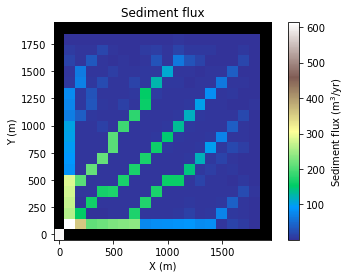

In [6]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
plot = plt.subplot()

#Show sediment flux map
imshow_grid(mg, 'sediment__flux', plot_name='Sediment flux', var_name = 'Sediment flux', var_units=r'm$^3$/yr', grid_units=('m', 'm'), cmap='terrain')

In [7]:
#Export figure to image
fig.savefig('sediment_flux_map.eps')

### Sedimentograph

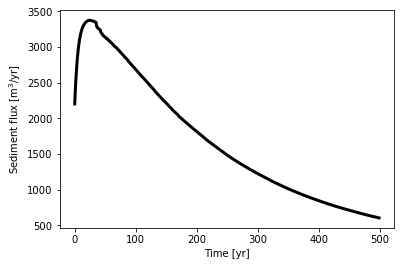

In [8]:
#Instantiate figure
fig = plt.figure()

#Instantiate subplot
sedfluxplot = plt.subplot()

#Plot data
sedfluxplot.plot(np.arange(500),sed_flux, color = 'k', linewidth = 3)

#Add axis labels
sedfluxplot.set_xlabel('Time [yr]')
sedfluxplot.set_ylabel(r'Sediment flux [m$^3$/yr]')

In [9]:
#Export figure to image
fig.savefig('sedimentograph.eps')